### 전체 환자 사망 여부 예측

In [1]:
import pandas as pd
df = pd.read_csv('/Users/hwangjeonghyun/COVID-19-Machine-Learning/data/processed/covid_preprocessed_all_patients.csv')

In [2]:
df.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEATH,PREGNANT_CLEAN
0,1,1,65,2,2,2,2,1,2,2,2,2,2,3,1,No
1,2,1,72,2,2,2,2,1,2,2,1,1,2,5,1,NotApplicable
2,2,2,55,1,2,2,2,2,2,2,2,2,2,3,1,NotApplicable
3,1,2,53,2,2,2,2,2,2,2,2,2,2,7,1,No
4,2,2,68,1,2,2,2,1,2,2,2,2,2,3,1,NotApplicable


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 범주형/수치형 컬럼 정의
categorical_cols = [
    "CLASIFFICATION_FINAL",            # 전체 환자 분석에서는 포함(원핫)
    "SEX","PREGNANT_CLEAN","PNEUMONIA","DIABETES","COPD","ASTHMA","INMSUPR",
    "HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY",
    "RENAL_CHRONIC","TOBACCO"
]

# X/y 분리
y = df["DEATH"]
X = df.drop(columns=["DEATH"])

# 원-핫 인코딩 (drop_first=False: 모든 범주 보존)
X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

print("최종 Feature shape:", X.shape)
print("Feature 예시:", X.columns[:50].tolist())

최종 Feature shape: (1048575, 47)
Feature 예시: ['AGE', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2', 'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4', 'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6', 'CLASIFFICATION_FINAL_7', 'SEX_1', 'SEX_2', 'PREGNANT_CLEAN_No', 'PREGNANT_CLEAN_NotApplicable', 'PREGNANT_CLEAN_Unknown', 'PREGNANT_CLEAN_Yes', 'PNEUMONIA_1', 'PNEUMONIA_2', 'PNEUMONIA_99', 'DIABETES_1', 'DIABETES_2', 'DIABETES_Unknown', 'COPD_1', 'COPD_2', 'COPD_Unknown', 'ASTHMA_1', 'ASTHMA_2', 'ASTHMA_Unknown', 'INMSUPR_1', 'INMSUPR_2', 'INMSUPR_Unknown', 'HIPERTENSION_1', 'HIPERTENSION_2', 'HIPERTENSION_Unknown', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'OTHER_DISEASE_Unknown', 'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'CARDIOVASCULAR_Unknown', 'OBESITY_1', 'OBESITY_2', 'OBESITY_Unknown', 'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'RENAL_CHRONIC_Unknown', 'TOBACCO_1', 'TOBACCO_2', 'TOBACCO_Unknown']


In [4]:
# 라이브러리, 기본 설정
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, average_precision_score)
from sklearn.utils import shuffle
from joblib import dump, load
import json, os

# 설정
GLOBAL_RS = 42
N_RUNS = 10   # 반복 횟수
ARTIFACT_DIR = "./modeling_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


In [5]:
# 데이터 6:2:2 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=GLOBAL_RS, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=GLOBAL_RS, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("사망 비율 — train:{:.4f}  val:{:.4f}  test:{:.4f}".format(
    np.mean(y_train), np.mean(y_val), np.mean(y_test)))


Train: (629145, 47) Val: (209715, 47) Test: (209715, 47)
사망 비율 — train:0.0734  val:0.0734  test:0.0734


In [7]:
scaler = StandardScaler()
if "AGE" in X_train.columns:
    scaler.fit(X_train[["AGE"]])
    X_train.loc[:, "AGE"] = scaler.transform(X_train[["AGE"]]).astype(float)
    X_val.loc[:,   "AGE"] = scaler.transform(X_val[["AGE"]]).astype(float)
    X_test.loc[:,  "AGE"] = scaler.transform(X_test[["AGE"]]).astype(float)


In [ ]:
# 하이퍼파라미터 탐색
base = LogisticRegression(
    solver='saga',
    max_iter=2000,   
    n_jobs=-1,
    class_weight='balanced',
    random_state=GLOBAL_RS,
    tol=1e-3
)

param_grid = [
    {"penalty": ["l1", "l2"], "C": np.logspace(-2, 2, 6)},        
    {"penalty": ["elasticnet"], "C": np.logspace(-2, 2, 6), "l1_ratio": [0.5]}  # elasticnet 단순화
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_RS)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)  # Train만 사용

best_params_fixed = grid.best_params_
best_cv_auc = grid.best_score_
print("Best params (fixed):", best_params_fixed)
print("CV AUC (Train CV):", best_cv_auc)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params (fixed): {'C': np.float64(15.848931924611142), 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
CV AUC (Train CV): 0.9272228296698457


In [9]:
# 고정된 HP로 10회 학습(시드만 변경) → Val에서 베스트 선택 + 체크포인트 저장
run_records = []
best_val_auc = -np.inf
best_run_idx = -1
best_model = None

for rseed in range(N_RUNS):
    print(f"\n=== Fixed-HP Run {rseed+1}/{N_RUNS} ===")

    # 시드별로 Train만 섞어 학습
    X_tr, y_tr = shuffle(X_train, y_train, random_state=rseed)

    model = LogisticRegression(
        **best_params_fixed,
        solver='saga',
        max_iter=2000,
        n_jobs=-1,
        class_weight='balanced',
        random_state=rseed   # 시드만 변경
    )
    model.fit(X_tr, y_tr)

    # 고정된 Val로 평가 (선택/기록용)
    val_prob = model.predict_proba(X_val)[:, 1]
    val_auc  = roc_auc_score(y_val, val_prob)
    val_pred05 = (val_prob >= 0.5).astype(int)

    rec = {
        "run": rseed,
        "val_auc": float(val_auc),
        "val_acc@0.5": float(accuracy_score(y_val, val_pred05)),
        "val_f1@0.5": float(f1_score(y_val, val_pred05)),
        "val_recall@0.5": float(recall_score(y_val, val_pred05)),
        "val_precision@0.5": float(precision_score(y_val, val_pred05))
    }
    run_records.append(rec)
    print(f"VAL AUC: {val_auc:.4f}")

    # 베스트 갱신 시 즉시 저장(체크포인트)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model
        best_run_idx = rseed

        dump(best_model, f"{ARTIFACT_DIR}/best_checkpoint_logistic.joblib")
        with open(f"{ARTIFACT_DIR}/checkpoint_meta_logistic.json", "w") as f:
            json.dump({
                "selected_run": int(best_run_idx),
                "best_val_auc": float(best_val_auc),
                "fixed_best_params": best_params_fixed
            }, f, ensure_ascii=False, indent=2)
        print(f"[Checkpoint saved] Run {best_run_idx}, VAL AUC={best_val_auc:.4f}")

top3 = sorted(run_records, key=lambda x: x["val_auc"], reverse=True)[:3]
print("\nTop runs by VAL AUC:\n", top3)



=== Fixed-HP Run 1/10 ===
VAL AUC: 0.9275
[Checkpoint saved] Run 0, VAL AUC=0.9275

=== Fixed-HP Run 2/10 ===
VAL AUC: 0.9275
[Checkpoint saved] Run 1, VAL AUC=0.9275

=== Fixed-HP Run 3/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 4/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 5/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 6/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 7/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 8/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 9/10 ===
VAL AUC: 0.9275

=== Fixed-HP Run 10/10 ===
VAL AUC: 0.9275

Top runs by VAL AUC:
 [{'run': 1, 'val_auc': 0.9274970382759069, 'val_acc@0.5': 0.8671768829125241, 'val_f1@0.5': 0.483659888408994, 'val_recall@0.5': 0.8477483917083631, 'val_precision@0.5': 0.33834742465895534}, {'run': 6, 'val_auc': 0.9274970364367391, 'val_acc@0.5': 0.8671768829125241, 'val_f1@0.5': 0.483659888408994, 'val_recall@0.5': 0.8477483917083631, 'val_precision@0.5': 0.33834742465895534}, {'run': 0, 'val_auc': 0.9274970337615858, 'val_acc@0.5': 0.8671768829125241, 'val

In [10]:
# 임계값 최적화 (F1 기준, Val만 사용)
def find_best_threshold_by_f1(y_true, y_prob, grid=np.linspace(0.05, 0.95, 37)):
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

from sklearn.metrics import average_precision_score

val_prob_best = best_model.predict_proba(X_val)[:, 1]
best_thresh, best_val_f1 = find_best_threshold_by_f1(y_val, val_prob_best)
val_pr_auc = average_precision_score(y_val, val_prob_best)

print(f"Best threshold(F1): {best_thresh:.2f} | VAL F1: {best_val_f1:.4f} | VAL PR-AUC: {val_pr_auc:.4f}")


Best threshold(F1): 0.82 | VAL F1: 0.5553 | VAL PR-AUC: 0.5358


In [11]:
# Train+Val 재학습 → 최종 모델 확정
final_model = LogisticRegression(
    **best_params_fixed,
    solver='saga',
    max_iter=2000,
    n_jobs=-1,
    class_weight='balanced', # 불균형 데이터 대응
    random_state=0   # 최종 모델 재현성용 고정 시드
)
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val])
)
print("Final model trained on Train+Val.")


Final model trained on Train+Val.


In [12]:
# Test 1회 평가 (0.5 & 최적 임계값 비교)
def evaluate_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"ACC: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {prec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

test_prob = final_model.predict_proba(X_test)[:, 1]
evaluate_binary(y_test, test_prob, threshold=0.5, title="Test @0.5")
evaluate_binary(y_test, test_prob, threshold=best_thresh, title="Test @optimal threshold (F1 from VAL)")


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



=== Test @0.5 ===
Threshold: 0.50
ROC-AUC: 0.9269 | PR-AUC: 0.5363
ACC: 0.8689 | F1: 0.4860 | Recall: 0.8448 | Precision: 0.3412
Confusion matrix [[TN FP],[FN TP]]:
 [[169222  25105]
 [  2388  13000]]
              precision    recall  f1-score   support

           0     0.9861    0.8708    0.9249    194327
           1     0.3412    0.8448    0.4860     15388

    accuracy                         0.8689    209715
   macro avg     0.6636    0.8578    0.7055    209715
weighted avg     0.9388    0.8689    0.8927    209715


=== Test @optimal threshold (F1 from VAL) ===
Threshold: 0.82
ROC-AUC: 0.9269 | PR-AUC: 0.5363
ACC: 0.9256 | F1: 0.5569 | Recall: 0.6371 | Precision: 0.4946
Confusion matrix [[TN FP],[FN TP]]:
 [[184307  10020]
 [  5584   9804]]
              precision    recall  f1-score   support

           0     0.9706    0.9484    0.9594    194327
           1     0.4946    0.6371    0.5569     15388

    accuracy                         0.9256    209715
   macro avg     0.7326

In [13]:
# 최종 저장 + 재로딩 검증(동일성 체크)
dump(final_model, f"{ARTIFACT_DIR}/best_logreg_FINAL_logistic.joblib")
with open(f"{ARTIFACT_DIR}/metadata_logistic.json", "w") as f:
    json.dump({
        "selected_run": int(best_run_idx),
        "best_val_auc": float(best_val_auc),
        "best_threshold(F1)": float(best_thresh),
        "fixed_best_params": best_params_fixed,
        "n_runs": int(N_RUNS),
        "run_records_top3": top3
    }, f, ensure_ascii=False, indent=2)

# 재로딩 검증
loaded = load(f"{ARTIFACT_DIR}/best_logreg_FINAL_logistic.joblib")
p1 = final_model.predict_proba(X_test)[:, 1]
p2 = loaded.predict_proba(X_test)[:, 1]
assert np.allclose(p1, p2), "Reloaded predictions differ!"
print("Reloaded predictions are identical")


Reloaded predictions are identical


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


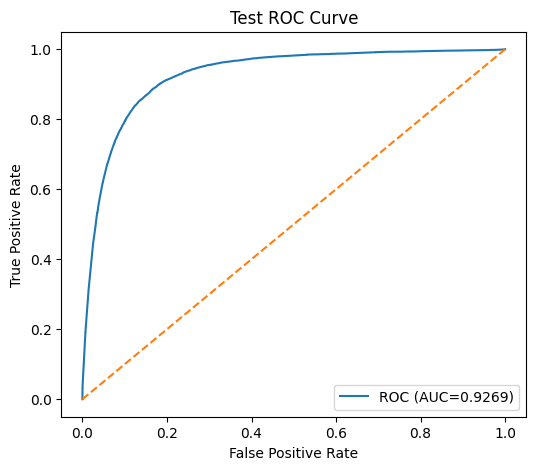

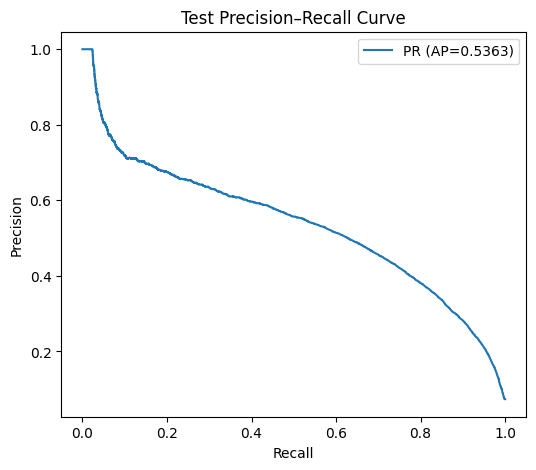

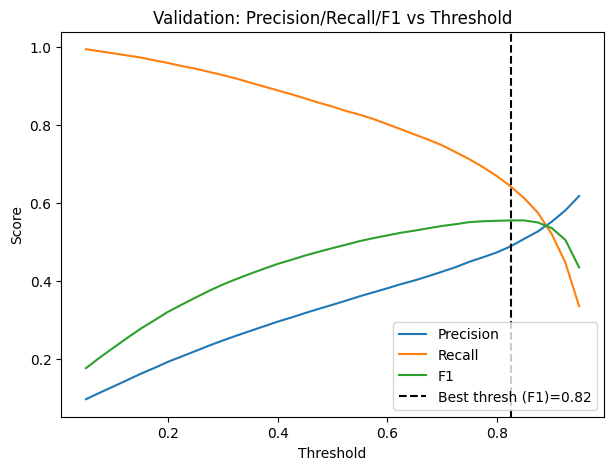

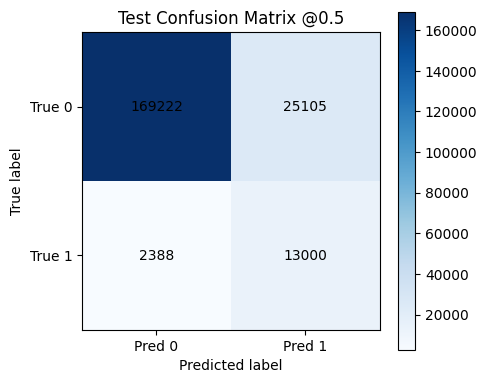

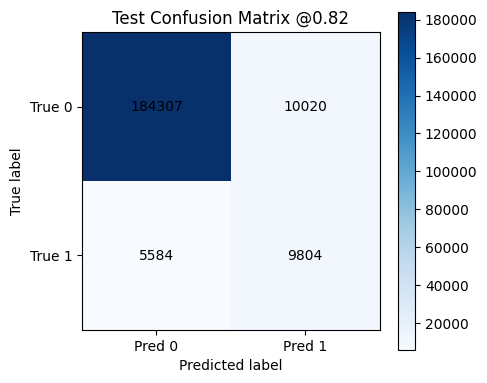

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# 확률
val_prob_best = final_model.predict_proba(X_val)[:, 1]
test_prob = final_model.predict_proba(X_test)[:, 1]

# ---------------------------
# 1) ROC Curve (Test)
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 2) Precision–Recall Curve (Test)
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, test_prob)
pr_auc = average_precision_score(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------------------
# 3) Threshold vs Precision/Recall/F1 (Validation 기준)
# ---------------------------
def curve_threshold_metrics(y_true, y_prob, grid=np.linspace(0.05,0.95,37)):
    precs, recs, f1s = [], [], []
    for t in grid:
        y_pred = (y_prob >= t).astype(int)
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    return grid, precs, recs, f1s

ts, precs, recs, f1s = curve_threshold_metrics(y_val, val_prob_best)

plt.figure(figsize=(7,5))
plt.plot(ts, precs, label="Precision")
plt.plot(ts, recs,  label="Recall")
plt.plot(ts, f1s,   label="F1")
plt.axvline(best_thresh, linestyle="--", color="k", label=f"Best thresh (F1)={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Validation: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.show()

# ---------------------------
# 4) Confusion Matrix (Test @0.5 vs @best_thresh)
# ---------------------------
def plot_cm(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center", color="black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

plot_cm(y_test, test_prob, 0.5, "Test Confusion Matrix @0.5")
plot_cm(y_test, test_prob, best_thresh, f"Test Confusion Matrix @{best_thresh:.2f}")


### Resampling
- 언더샘플링 (Undersampling)

    - 다수 클래스(생존자) 데이터를 줄여서, 소수 클래스(사망자)와 비율을 맞춤

    - 장점: 빠르고 단순, 클래스 균형 확보

    - 단점: 데이터 손실이 커서 중요한 정보가 빠질 수 있음
- 오버샘플링 (Oversampling)

    - 소수 클래스(사망자) 데이터를 복제하거나 합성해서 늘려줌

    - 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique)

    - 장점: 데이터 손실 없음

    - 단점: 과적합 위험(특히 단순 복제일 경우)

In [ ]:
# === Resampling at fixed threshold = 0.5 ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix, accuracy_score
)
import numpy as np
import pandas as pd

# 1) y를 0/1로 (1=사망, 0=생존) 
y_train_bin = (y_train == 1).astype(int)
y_val_bin   = (y_val   == 1).astype(int)
y_test_bin  = (y_test  == 1).astype(int)

# 2) AGE만 스케일링(누수 방지: 파이프라인 내부에서 train에만 fit)
preproc = ColumnTransformer(
    transformers=[("num", StandardScaler(), ["AGE"])],
    remainder="passthrough"
)

def make_pipe(sampler=None, random_state=42):
    clf = LogisticRegression(
        solver="saga", max_iter=2000, n_jobs=-1,
        class_weight=None,        # 샘플링과 동시 사용 시 과보정 가능 → 여기선 off
        random_state=random_state
    )
    steps = [("prep", preproc)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", clf))
    return ImbPipeline(steps=steps)

pipelines = {
    "UnderSampler(RUS)": make_pipe(RandomUnderSampler(random_state=42)),
    "OverSampler(ROS)":  make_pipe(RandomOverSampler(random_state=42)),
}

def evaluate_fixed_thr(y_true, prob, thr=0.5):
    pred = (prob >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, pred)
    roc = roc_auc_score(y_true, prob)
    prc = average_precision_score(y_true, prob)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {"ACC":acc, "F1":f1, "Precision":p, "Recall":r, "ROC-AUC":roc, "PR-AUC":prc,
            "TN":tn, "FP":fp, "FN":fn, "TP":tp}

rows = []
for name, pipe in pipelines.items():
    print(f"\n=== {name} @thr=0.50 ===")
    pipe.fit(X_train, y_train_bin)               
    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    val_res  = evaluate_fixed_thr(y_val_bin,  val_prob,  thr=0.5)
    test_res = evaluate_fixed_thr(y_test_bin, test_prob, thr=0.5)

    print(f"VAL  — F1:{val_res['F1']:.4f}  Rec:{val_res['Recall']:.4f}  "
          f"Prec:{val_res['Precision']:.4f}  AUC:{val_res['ROC-AUC']:.4f}  PR-AUC:{val_res['PR-AUC']:.4f}")
    print(f"TEST — F1:{test_res['F1']:.4f}  Rec:{test_res['Recall']:.4f}  "
          f"Prec:{test_res['Precision']:.4f}  AUC:{test_res['ROC-AUC']:.4f}  PR-AUC:{test_res['PR-AUC']:.4f}")
    print("TEST CM [[TN FP],[FN TP]]:", test_res["TN"], test_res["FP"], test_res["FN"], test_res["TP"])

    rows.append({"Model":name, **{k:(round(v,4) if isinstance(v,float) else v) for k,v in test_res.items()}})

result_05 = pd.DataFrame(rows).sort_values(by="F1", ascending=False)
print("\n=== Resampling (thr=0.50) — TEST summary ===")
print(result_05.to_string(index=False))



=== UnderSampler(RUS) @thr=0.50 ===


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


VAL  — F1:0.4831  Rec:0.8482  Prec:0.3377  AUC:0.9274  PR-AUC:0.5317
TEST — F1:0.4850  Rec:0.8459  Prec:0.3400  AUC:0.9267  PR-AUC:0.5332
TEST CM [[TN FP],[FN TP]]: 169055 25272 2371 13017

=== OverSampler(ROS) @thr=0.50 ===


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


VAL  — F1:0.4835  Rec:0.8475  Prec:0.3382  AUC:0.9275  PR-AUC:0.5356
TEST — F1:0.4853  Rec:0.8451  Prec:0.3404  AUC:0.9268  PR-AUC:0.5361
TEST CM [[TN FP],[FN TP]]: 169129 25198 2383 13005

=== Resampling (thr=0.50) — TEST summary ===
            Model    ACC     F1  Precision  Recall  ROC-AUC  PR-AUC     TN    FP   FN    TP
 OverSampler(ROS) 0.8685 0.4853     0.3404  0.8451   0.9268  0.5361 169129 25198 2383 13005
UnderSampler(RUS) 0.8682 0.4850     0.3400  0.8459   0.9267  0.5332 169055 25272 2371 13017


### 코로나 양성 환자(확진자) 사망 여부 예측

In [16]:
import pandas as pd
df = pd.read_csv('/Users/hwangjeonghyun/COVID-19-Machine-Learning/data/processed/covid_preprocessed_positive_patients.csv')

In [17]:
df.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEATH,PREGNANT_CLEAN
0,1,1,65,2,2,2,2,1,2,2,2,2,2,3,1,No
1,2,2,55,1,2,2,2,2,2,2,2,2,2,3,1,NotApplicable
2,2,2,68,1,2,2,2,1,2,2,2,2,2,3,1,NotApplicable
3,1,1,40,2,2,2,2,2,2,2,2,2,2,3,0,No
4,1,2,64,2,2,2,2,2,2,2,2,2,2,3,0,No


In [ ]:
# 범주형/수치형 컬럼 정의 (확진자만이므로 CLASIFFICATION_FINAL 제외)
categorical_cols = [
    "SEX","PREGNANT_CLEAN","PNEUMONIA","DIABETES","COPD","ASTHMA","INMSUPR",
    "HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY",
    "RENAL_CHRONIC","TOBACCO"
]
numeric_cols = ["AGE"]  

# X/y 분리
y = df["DEATH"]
X = df.drop(columns=["DEATH", "CLASIFFICATION_FINAL"], errors="ignore")

# 원-핫 인코딩
X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

print("최종 Feature shape:", X.shape)
print("Feature 예시:", X.columns[:50].tolist())

최종 Feature shape: (391979, 40)
Feature 예시: ['AGE', 'SEX_1', 'SEX_2', 'PREGNANT_CLEAN_No', 'PREGNANT_CLEAN_NotApplicable', 'PREGNANT_CLEAN_Unknown', 'PREGNANT_CLEAN_Yes', 'PNEUMONIA_1', 'PNEUMONIA_2', 'PNEUMONIA_99', 'DIABETES_1', 'DIABETES_2', 'DIABETES_Unknown', 'COPD_1', 'COPD_2', 'COPD_Unknown', 'ASTHMA_1', 'ASTHMA_2', 'ASTHMA_Unknown', 'INMSUPR_1', 'INMSUPR_2', 'INMSUPR_Unknown', 'HIPERTENSION_1', 'HIPERTENSION_2', 'HIPERTENSION_Unknown', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'OTHER_DISEASE_Unknown', 'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'CARDIOVASCULAR_Unknown', 'OBESITY_1', 'OBESITY_2', 'OBESITY_Unknown', 'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'RENAL_CHRONIC_Unknown', 'TOBACCO_1', 'TOBACCO_2', 'TOBACCO_Unknown']


In [19]:
# 라이브러리, 기본 설정
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, average_precision_score)
from sklearn.utils import shuffle
from joblib import dump, load
import json, os

# 설정
GLOBAL_RS = 42
N_RUNS = 10   # 반복 횟수
ARTIFACT_DIR = "./modeling_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


In [20]:
# 데이터 6:2:2 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=GLOBAL_RS, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=GLOBAL_RS, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("사망 비율 — train:{:.4f}  val:{:.4f}  test:{:.4f}".format(
    np.mean(y_train), np.mean(y_val), np.mean(y_test)))


Train: (235187, 40) Val: (78396, 40) Test: (78396, 40)
사망 비율 — train:0.1384  val:0.1384  test:0.1384


In [21]:
scaler = StandardScaler()
if "AGE" in X_train.columns:
    scaler.fit(X_train[["AGE"]])
    X_train.loc[:, "AGE"] = scaler.transform(X_train[["AGE"]]).astype(float)
    X_val.loc[:,   "AGE"] = scaler.transform(X_val[["AGE"]]).astype(float)
    X_test.loc[:,  "AGE"] = scaler.transform(X_test[["AGE"]]).astype(float)


/var/folders/zx/cn5rp85x1gg2mjyqzz1tnj480000gn/T/ipykernel_1972/3019789422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.07041565  0.11161834 -1.3446536  ...  0.77907631 -0.98058561
 -0.98058561]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, "AGE"] = scaler.transform(X_train[["AGE"]]).astype(float)
/var/folders/zx/cn5rp85x1gg2mjyqzz1tnj480000gn/T/ipykernel_1972/3019789422.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.77907631 -0.31312764 -0.73787362 ... -1.10194161  1.26450029
 -0.07041565]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_val.loc[:,   "AGE"] = scaler.transform(X_val[["AGE"]]).astype(float)
/var/folders/zx/cn5rp85x1gg2mjyqzz1tnj480000gn/T/ipykernel_1972/3019789422.py:6: FutureWarning: Setting an item of incom

In [ ]:
# 하이퍼파라미터 탐색
base = LogisticRegression(
    solver='saga',
    max_iter=2000,   
    n_jobs=-1,
    class_weight='balanced',
    random_state=GLOBAL_RS,
    tol=1e-3
)

param_grid = [
    {"penalty": ["l1", "l2"], "C": np.logspace(-2, 2, 6)},        
    {"penalty": ["elasticnet"], "C": np.logspace(-2, 2, 6), "l1_ratio": [0.5]}  # elasticnet 단순화
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_RS)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)  # Train만 사용

best_params_fixed = grid.best_params_
best_cv_auc = grid.best_score_
print("Best params (fixed):", best_params_fixed)
print("CV AUC (Train CV):", best_cv_auc)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params (fixed): {'C': np.float64(0.06309573444801933), 'penalty': 'l1'}
CV AUC (Train CV): 0.909262292866333


In [23]:
# 고정된 HP로 10회 학습(시드만 변경) → Val에서 베스트 선택 + 체크포인트 저장
run_records = []
best_val_auc = -np.inf
best_run_idx = -1
best_model = None

for rseed in range(N_RUNS):
    print(f"\n=== Fixed-HP Run {rseed+1}/{N_RUNS} ===")

    # 시드별로 Train만 섞어 학습
    X_tr, y_tr = shuffle(X_train, y_train, random_state=rseed)

    model = LogisticRegression(
        **best_params_fixed,
        solver='saga',
        max_iter=2000,
        n_jobs=-1,
        class_weight='balanced',
        random_state=rseed   # 시드만 변경
    )
    model.fit(X_tr, y_tr)

    # 고정된 Val로 평가 (선택/기록용)
    val_prob = model.predict_proba(X_val)[:, 1]
    val_auc  = roc_auc_score(y_val, val_prob)
    val_pred05 = (val_prob >= 0.5).astype(int)

    rec = {
        "run": rseed,
        "val_auc": float(val_auc),
        "val_acc@0.5": float(accuracy_score(y_val, val_pred05)),
        "val_f1@0.5": float(f1_score(y_val, val_pred05)),
        "val_recall@0.5": float(recall_score(y_val, val_pred05)),
        "val_precision@0.5": float(precision_score(y_val, val_pred05))
    }
    run_records.append(rec)
    print(f"VAL AUC: {val_auc:.4f}")

    # 베스트 갱신 시 즉시 저장(체크포인트)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model
        best_run_idx = rseed

        dump(best_model, f"{ARTIFACT_DIR}/best_checkpoint_logistic.joblib")
        with open(f"{ARTIFACT_DIR}/checkpoint_meta_logistic.json", "w") as f:
            json.dump({
                "selected_run": int(best_run_idx),
                "best_val_auc": float(best_val_auc),
                "fixed_best_params": best_params_fixed
            }, f, ensure_ascii=False, indent=2)
        print(f"[Checkpoint saved] Run {best_run_idx}, VAL AUC={best_val_auc:.4f}")

top3 = sorted(run_records, key=lambda x: x["val_auc"], reverse=True)[:3]
print("\nTop runs by VAL AUC:\n", top3)



=== Fixed-HP Run 1/10 ===
VAL AUC: 0.9073
[Checkpoint saved] Run 0, VAL AUC=0.9073

=== Fixed-HP Run 2/10 ===
VAL AUC: 0.9073
[Checkpoint saved] Run 1, VAL AUC=0.9073

=== Fixed-HP Run 3/10 ===
VAL AUC: 0.9073

=== Fixed-HP Run 4/10 ===
VAL AUC: 0.9073
[Checkpoint saved] Run 3, VAL AUC=0.9073

=== Fixed-HP Run 5/10 ===
VAL AUC: 0.9073

=== Fixed-HP Run 6/10 ===
VAL AUC: 0.9073

=== Fixed-HP Run 7/10 ===
VAL AUC: 0.9073

=== Fixed-HP Run 8/10 ===
VAL AUC: 0.9073

=== Fixed-HP Run 9/10 ===
VAL AUC: 0.9073

=== Fixed-HP Run 10/10 ===
VAL AUC: 0.9073

Top runs by VAL AUC:
 [{'run': 3, 'val_auc': 0.9073406167810987, 'val_acc@0.5': 0.836126843206286, 'val_f1@0.5': 0.5848440782032639, 'val_recall@0.5': 0.8342398819950216, 'val_precision@0.5': 0.45024380535376657}, {'run': 1, 'val_auc': 0.9073405935793692, 'val_acc@0.5': 0.836126843206286, 'val_f1@0.5': 0.5848440782032639, 'val_recall@0.5': 0.8342398819950216, 'val_precision@0.5': 0.45024380535376657}, {'run': 8, 'val_auc': 0.9073405287510078

In [24]:
# 임계값 최적화 (F1 기준, Val만 사용)
def find_best_threshold_by_f1(y_true, y_prob, grid=np.linspace(0.05, 0.95, 37)):
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

from sklearn.metrics import average_precision_score

val_prob_best = best_model.predict_proba(X_val)[:, 1]
best_thresh, best_val_f1 = find_best_threshold_by_f1(y_val, val_prob_best)
val_pr_auc = average_precision_score(y_val, val_prob_best)

print(f"Best threshold(F1): {best_thresh:.2f} | VAL F1: {best_val_f1:.4f} | VAL PR-AUC: {val_pr_auc:.4f}")


Best threshold(F1): 0.68 | VAL F1: 0.6089 | VAL PR-AUC: 0.5776


In [25]:
# Train+Val 재학습 → 최종 모델 확정
final_model = LogisticRegression(
    **best_params_fixed,
    solver='saga',
    max_iter=2000,
    n_jobs=-1,
    class_weight='balanced', # 불균형 데이터 대응
    random_state=0   # 최종 모델 재현성용 고정 시드
)
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val])
)
print("Final model trained on Train+Val.")


Final model trained on Train+Val.


In [26]:
# Test 1회 평가 (0.5 & 최적 임계값 비교)
def evaluate_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"ACC: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {prec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

test_prob = final_model.predict_proba(X_test)[:, 1]
evaluate_binary(y_test, test_prob, threshold=0.5, title="Test @0.5")
evaluate_binary(y_test, test_prob, threshold=best_thresh, title="Test @optimal threshold (F1 from VAL)")



=== Test @0.5 ===
Threshold: 0.50
ROC-AUC: 0.9104 | PR-AUC: 0.5918
ACC: 0.8387 | F1: 0.5910 | Recall: 0.8424 | Precision: 0.4552
Confusion matrix [[TN FP],[FN TP]]:
 [[56612 10937]
 [ 1710  9137]]
              precision    recall  f1-score   support

           0     0.9707    0.8381    0.8995     67549
           1     0.4552    0.8424    0.5910     10847

    accuracy                         0.8387     78396
   macro avg     0.7129    0.8402    0.7453     78396
weighted avg     0.8994    0.8387    0.8568     78396


=== Test @optimal threshold (F1 from VAL) ===
Threshold: 0.68
ROC-AUC: 0.9104 | PR-AUC: 0.5918
ACC: 0.8714 | F1: 0.6144 | Recall: 0.7407 | Precision: 0.5249
Confusion matrix [[TN FP],[FN TP]]:
 [[60277  7272]
 [ 2813  8034]]
              precision    recall  f1-score   support

           0     0.9554    0.8923    0.9228     67549
           1     0.5249    0.7407    0.6144     10847

    accuracy                         0.8714     78396
   macro avg     0.7402    0.81

/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [27]:
# 최종 저장 + 재로딩 검증(동일성 체크)
dump(final_model, f"{ARTIFACT_DIR}/best_logreg_FINAL_logistic_positive.joblib")
with open(f"{ARTIFACT_DIR}/metadata_logistic_positive.json", "w") as f:
    json.dump({
        "selected_run": int(best_run_idx),
        "best_val_auc": float(best_val_auc),
        "best_threshold(F1)": float(best_thresh),
        "fixed_best_params": best_params_fixed,
        "n_runs": int(N_RUNS),
        "run_records_top3": top3
    }, f, ensure_ascii=False, indent=2)

# 재로딩 검증
loaded = load(f"{ARTIFACT_DIR}/best_logreg_FINAL_logistic_positive.joblib")
p1 = final_model.predict_proba(X_test)[:, 1]
p2 = loaded.predict_proba(X_test)[:, 1]
assert np.allclose(p1, p2), "Reloaded predictions differ!"
print("Reloaded predictions are identical")


Reloaded predictions are identical


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


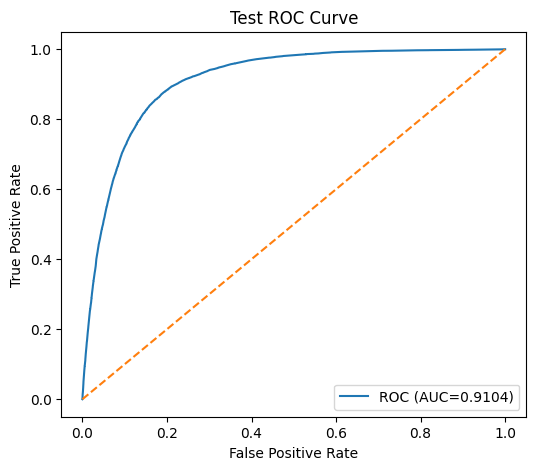

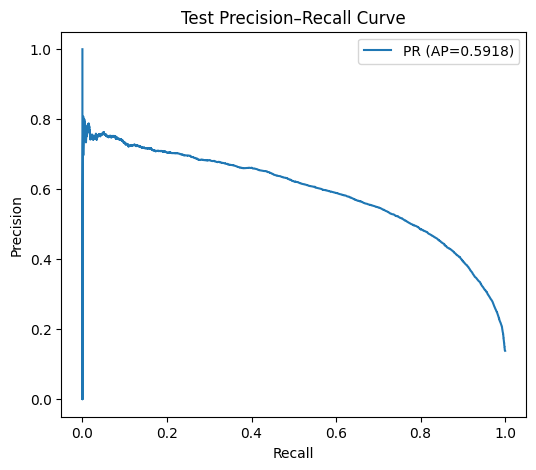

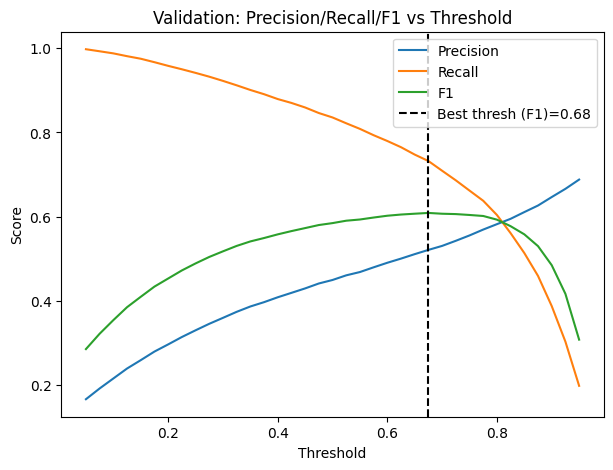

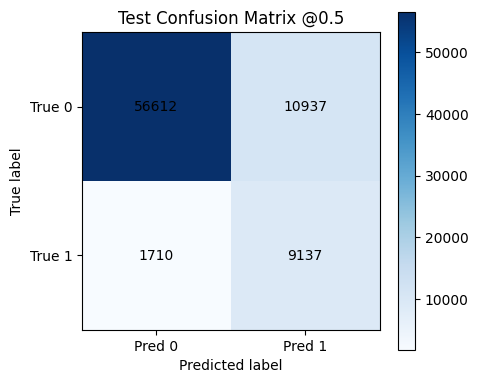

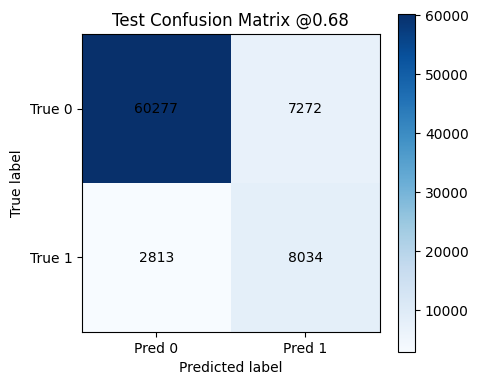

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# 확률
val_prob_best = final_model.predict_proba(X_val)[:, 1]
test_prob = final_model.predict_proba(X_test)[:, 1]

# ---------------------------
# 1) ROC Curve (Test)
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 2) Precision–Recall Curve (Test)
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, test_prob)
pr_auc = average_precision_score(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------------------
# 3) Threshold vs Precision/Recall/F1 (Validation 기준)
# ---------------------------
def curve_threshold_metrics(y_true, y_prob, grid=np.linspace(0.05,0.95,37)):
    precs, recs, f1s = [], [], []
    for t in grid:
        y_pred = (y_prob >= t).astype(int)
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    return grid, precs, recs, f1s

ts, precs, recs, f1s = curve_threshold_metrics(y_val, val_prob_best)

plt.figure(figsize=(7,5))
plt.plot(ts, precs, label="Precision")
plt.plot(ts, recs,  label="Recall")
plt.plot(ts, f1s,   label="F1")
plt.axvline(best_thresh, linestyle="--", color="k", label=f"Best thresh (F1)={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Validation: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.show()

# ---------------------------
# 4) Confusion Matrix (Test @0.5 vs @best_thresh)
# ---------------------------
def plot_cm(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center", color="black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

plot_cm(y_test, test_prob, 0.5, "Test Confusion Matrix @0.5")
plot_cm(y_test, test_prob, best_thresh, f"Test Confusion Matrix @{best_thresh:.2f}")


In [ ]:
# === Resampling at fixed threshold = 0.5 ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix, accuracy_score
)
import numpy as np
import pandas as pd

# 1) y를 0/1로 (1=사망, 0=생존) 
y_train_bin = (y_train == 1).astype(int)
y_val_bin   = (y_val   == 1).astype(int)
y_test_bin  = (y_test  == 1).astype(int)

# 2) AGE만 스케일링(누수 방지: 파이프라인 내부에서 train에만 fit)
preproc = ColumnTransformer(
    transformers=[("num", StandardScaler(), ["AGE"])],
    remainder="passthrough"
)

def make_pipe(sampler=None, random_state=42):
    clf = LogisticRegression(
        solver="saga", max_iter=2000, n_jobs=-1,
        class_weight=None,        # 샘플링과 동시 사용 시 과보정 가능 → 여기선 off
        random_state=random_state
    )
    steps = [("prep", preproc)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", clf))
    return ImbPipeline(steps=steps)

pipelines = {
    "UnderSampler(RUS)": make_pipe(RandomUnderSampler(random_state=42)),
    "OverSampler(ROS)":  make_pipe(RandomOverSampler(random_state=42)),
}

def evaluate_fixed_thr(y_true, prob, thr=0.5):
    pred = (prob >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, pred)
    roc = roc_auc_score(y_true, prob)
    prc = average_precision_score(y_true, prob)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {"ACC":acc, "F1":f1, "Precision":p, "Recall":r, "ROC-AUC":roc, "PR-AUC":prc,
            "TN":tn, "FP":fp, "FN":fn, "TP":tp}

rows = []
for name, pipe in pipelines.items():
    print(f"\n=== {name} @thr=0.50 ===")
    pipe.fit(X_train, y_train_bin)               # 파이프라인이 내부에서만 스케일/리샘플링
    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    val_res  = evaluate_fixed_thr(y_val_bin,  val_prob,  thr=0.5)
    test_res = evaluate_fixed_thr(y_test_bin, test_prob, thr=0.5)

    print(f"VAL  — F1:{val_res['F1']:.4f}  Rec:{val_res['Recall']:.4f}  "
          f"Prec:{val_res['Precision']:.4f}  AUC:{val_res['ROC-AUC']:.4f}  PR-AUC:{val_res['PR-AUC']:.4f}")
    print(f"TEST — F1:{test_res['F1']:.4f}  Rec:{test_res['Recall']:.4f}  "
          f"Prec:{test_res['Precision']:.4f}  AUC:{test_res['ROC-AUC']:.4f}  PR-AUC:{test_res['PR-AUC']:.4f}")
    print("TEST CM [[TN FP],[FN TP]]:", test_res["TN"], test_res["FP"], test_res["FN"], test_res["TP"])

    rows.append({"Model":name, **{k:(round(v,4) if isinstance(v,float) else v) for k,v in test_res.items()}})

result_05 = pd.DataFrame(rows).sort_values(by="F1", ascending=False)
print("\n=== Resampling (thr=0.50) — TEST summary ===")
print(result_05.to_string(index=False))



=== UnderSampler(RUS) @thr=0.50 ===


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


VAL  — F1:0.5857  Rec:0.8351  Prec:0.4510  AUC:0.9073  PR-AUC:0.5774
TEST — F1:0.5922  Rec:0.8415  Prec:0.4569  AUC:0.9103  PR-AUC:0.5918
TEST CM [[TN FP],[FN TP]]: 56699 10850 1719 9128

=== OverSampler(ROS) @thr=0.50 ===


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


VAL  — F1:0.5849  Rec:0.8347  Prec:0.4502  AUC:0.9074  PR-AUC:0.5775
TEST — F1:0.5917  Rec:0.8418  Prec:0.4562  AUC:0.9103  PR-AUC:0.5919
TEST CM [[TN FP],[FN TP]]: 56663 10886 1716 9131

=== Resampling (thr=0.50) — TEST summary ===
            Model    ACC     F1  Precision  Recall  ROC-AUC  PR-AUC    TN    FP   FN   TP
UnderSampler(RUS) 0.8397 0.5922     0.4569  0.8415   0.9103  0.5918 56699 10850 1719 9128
 OverSampler(ROS) 0.8393 0.5917     0.4562  0.8418   0.9103  0.5919 56663 10886 1716 9131
